Hypothesis

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import geopandas as gpd

import plotly.express as px
import json

from scipy import stats

# supress warnings
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files = {
    '202211': '/content/drive/My Drive/Colab Notebooks/data-listings-detailed/listings_detailed_202211.csv',
    '202212': '/content/drive/My Drive/Colab Notebooks/data-listings-detailed/listings_detailed_202212.csv',
    '202301': '/content/drive/My Drive/Colab Notebooks/data-listings-detailed/listings_detailed_202301.csv',
    '202302': '/content/drive/My Drive/Colab Notebooks/data-listings-detailed/listings_detailed_202302.csv',
    '202303': '/content/drive/My Drive/Colab Notebooks/data-listings-detailed/listings_detailed_202303.csv',
    '202304': '/content/drive/My Drive/Colab Notebooks/data-listings-detailed/listings_detailed_202304.csv',
    '202305': '/content/drive/My Drive/Colab Notebooks/data-listings-detailed/listings_detailed_202305.csv',
    '202306': '/content/drive/My Drive/Colab Notebooks/data-listings-detailed/listings_detailed_202306.csv',
    '202307': '/content/drive/My Drive/Colab Notebooks/data-listings-detailed/listings_detailed_202307.csv',
    '202308': '/content/drive/My Drive/Colab Notebooks/data-listings-detailed/listings_detailed_202308.csv',
    '202309': '/content/drive/My Drive/Colab Notebooks/data-listings-detailed/listings_detailed_202309.csv',
    '202310': '/content/drive/My Drive/Colab Notebooks/data-listings-detailed/listings_detailed_202310.csv',
    '202211_summary': '/content/drive/My Drive/Colab Notebooks/data-listings-summary/listings_summary_202211.csv',
    '202212_summary': '/content/drive/My Drive/Colab Notebooks/data-listings-summary/listings_summary_202212.csv',
    '202301_summary': '/content/drive/My Drive/Colab Notebooks/data-listings-summary/listings_summary_202301.csv',
    '202302_summary': '/content/drive/My Drive/Colab Notebooks/data-listings-summary/listings_summary_202302.csv',
    '202303_summary': '/content/drive/My Drive/Colab Notebooks/data-listings-summary/listings_summary_202303.csv',
    '202304_summary': '/content/drive/My Drive/Colab Notebooks/data-listings-summary/listings_summary_202304.csv',
    '202305_summary': '/content/drive/My Drive/Colab Notebooks/data-listings-summary/listings_summary_202305.csv',
    '202306_summary': '/content/drive/My Drive/Colab Notebooks/data-listings-summary/listings_summary_202306.csv',
    '202307_summary': '/content/drive/My Drive/Colab Notebooks/data-listings-summary/listings_summary_202307.csv',
    '202308_summary': '/content/drive/My Drive/Colab Notebooks/data-listings-summary/listings_summary_202308.csv',
    '202309_summary': '/content/drive/My Drive/Colab Notebooks/data-listings-summary/listings_summary_202309.csv',
    '202310_summary': '/content/drive/My Drive/Colab Notebooks/data-listings-summary/listings_summary_202310.csv',
    'neighbourhoods_geo': '/content/drive/My Drive/Colab Notebooks/data/neighbourhoods.geojson',
    'boroughs_geo': '/content/drive/My Drive/Colab Notebooks/data/new-york-city-boroughs.geojson',
}

## compare four metrics

In [ ]:
# List of file paths for all the provided CSV files
file_paths = [
    files['202211_summary'],
    files['202212_summary'],
    files['202301_summary'],
    files['202302_summary'],
    files['202303_summary'],
    files['202304_summary'],
    files['202305_summary'],
    files['202306_summary'],
    files['202307_summary'],
    files['202308_summary'],
    files['202309_summary'],
    files['202310_summary'],
]

# load each file and add a column to denote the month of the data
# This will help us in tracking the changes over time

# Initialize an empty list to store the dataframes
df_list = []

# Loop through the file paths and read each one
for file_path in file_paths:
    # Extract the month from the file name
    month = file_path[-10:-4]

    # Read the CSV file
    df = pd.read_csv(file_path)

    # Add a column for the month
    df['month'] = month

    # Append the dataframe to the list
    df_list.append(df)

# Concatenate all the dataframes into one
combined_data = pd.concat(df_list, ignore_index=True)

# Checking the combined dataframe structure and the new 'month' column
# combined_data[['id', 'name', 'month']].head(), combined_data[['id', 'name', 'month']].tail()


In [ ]:
combined_data[['id', 'name', 'month']].head()

,id,name,month
0,2595,Skylit Midtown Castle,202211
1,5121,BlissArtsSpace!,202211
2,5136,"Spacious Brooklyn Duplex, Patio + Garden",202211
3,5178,Large Furnished Room Near B'way,202211
4,5203,Cozy Clean Guest Room - Family Apt,202211


In [ ]:
# Convert 'month' column to datetime object for easier manipulation
combined_data['month'] = pd.to_datetime(combined_data['month'], format='%Y%m')

# Check for any missing values in the key columns
missing_values = combined_data[['id', 'price', 'availability_365', 'number_of_reviews', 'month']].isnull().sum()

# Also, let's ensure the data types are correct, especially for the 'month' column and other columns we will use
data_types = combined_data[['id', 'price', 'availability_365', 'number_of_reviews', 'month']].dtypes

missing_values, data_types


(id                   0
 price                0
 availability_365     0
 number_of_reviews    0
 month                0
 dtype: int64,
 id                            int64
 price                         int64
 availability_365              int64
 number_of_reviews             int64
 month                datetime64[ns]
 dtype: object)

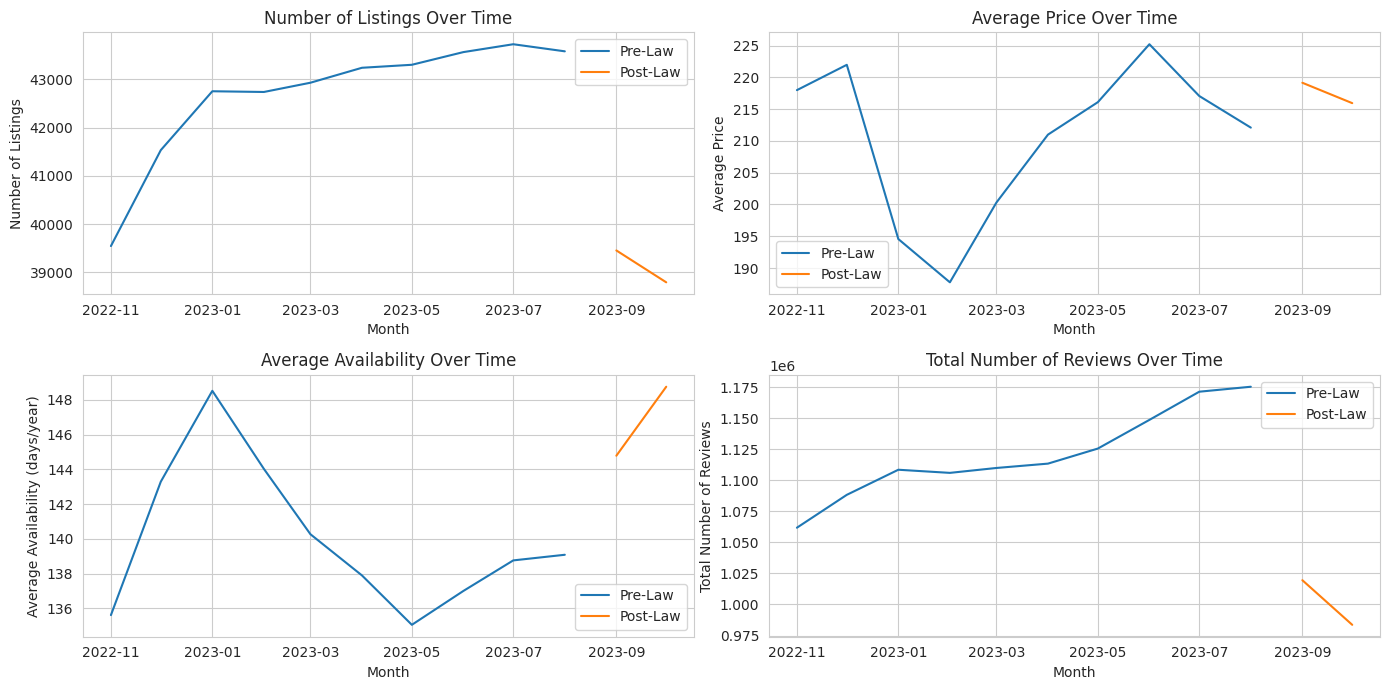

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Calculate descriptive statistics before the law took effect
pre_law_stats = combined_data[combined_data['month'] < '2023-09'].groupby('month').agg({
    'id': 'count',
    'price': 'mean',
    'availability_365': 'mean',
    'number_of_reviews': 'sum'
}).reset_index()

# Calculate descriptive statistics after the law took effect
post_law_stats = combined_data[combined_data['month'] >= '2023-09'].groupby('month').agg({
    'id': 'count',
    'price': 'mean',
    'availability_365': 'mean',
    'number_of_reviews': 'sum'
}).reset_index()

# Plot the trends over time
plt.figure(figsize=(14, 7))

# Number of listings
plt.subplot(2, 2, 1)
sns.lineplot(x='month', y='id', data=pre_law_stats, label='Pre-Law')
sns.lineplot(x='month', y='id', data=post_law_stats, label='Post-Law')
plt.title('Number of Listings Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Listings')

# Average price
plt.subplot(2, 2, 2)
sns.lineplot(x='month', y='price', data=pre_law_stats, label='Pre-Law')
sns.lineplot(x='month', y='price', data=post_law_stats, label='Post-Law')
plt.title('Average Price Over Time')
plt.xlabel('Month')
plt.ylabel('Average Price')

# Average availability
plt.subplot(2, 2, 3)
sns.lineplot(x='month', y='availability_365', data=pre_law_stats, label='Pre-Law')
sns.lineplot(x='month', y='availability_365', data=post_law_stats, label='Post-Law')
plt.title('Average Availability Over Time')
plt.xlabel('Month')
plt.ylabel('Average Availability (days/year)')

# Total number of reviews
plt.subplot(2, 2, 4)
sns.lineplot(x='month', y='number_of_reviews', data=pre_law_stats, label='Pre-Law')
sns.lineplot(x='month', y='number_of_reviews', data=post_law_stats, label='Post-Law')
plt.title('Total Number of Reviews Over Time')
plt.xlabel('Month')
plt.ylabel('Total Number of Reviews')

plt.tight_layout()
plt.show()


In [ ]:


# Function to perform t-test and return the p-value
def perform_ttest(pre_law_data, post_law_data):
    t_stat, p_value = stats.ttest_ind(pre_law_data, post_law_data, equal_var=False)
    return p_value

# Perform t-tests for each metric
p_values = {
    'Number of Listings': perform_ttest(pre_law_stats['id'], post_law_stats['id']),
    'Average Price': perform_ttest(pre_law_stats['price'], post_law_stats['price']),
    'Average Availability': perform_ttest(pre_law_stats['availability_365'], post_law_stats['availability_365']),
    'Total Number of Reviews': perform_ttest(pre_law_stats['number_of_reviews'], post_law_stats['number_of_reviews'])
}

p_values


{'Number of Listings': 0.0010414513303295021,
 'Average Price': 0.12060871311683345,
 'Average Availability': 0.10089683463896768,
 'Total Number of Reviews': 0.033510616499492336}

**Number of Listings**: The p-value is approximately 0.0010, which is less than the standard alpha level of 0.05. This indicates that the change in the number of listings is statistically significant, and it's unlikely to have occurred by chance.

**Average Price**: The p-value is approximately 0.1206, which is greater than 0.05. Therefore, we do not have enough evidence to suggest that the change in average price is statistically significant.

**Average Availability**: The p-value is approximately 0.1009, which is also greater than 0.05. This suggests that any change in the average availability of listings is not statistically significant.

**Total Number of Reviews**: The p-value is approximately 0.0335, which is just below the 0.05 threshold. This suggests that there is a statistically significant change in the total number of reviews.

In [ ]:
# Calculate descriptive statistics for average price by room type before the law took effect
pre_law_price_by_room_type = combined_data[combined_data['month'] < '2023-09'].groupby(['month', 'room_type'])['price'].mean().unstack()

# Calculate descriptive statistics for average price by room type after the law took effect
post_law_price_by_room_type = combined_data[combined_data['month'] >= '2023-09'].groupby(['month', 'room_type'])['price'].mean().unstack()

# Perform t-tests for average price by room type
p_values_by_room_type = {}
for room_type in pre_law_price_by_room_type.columns:
    pre_law_prices = pre_law_price_by_room_type[room_type].dropna()
    post_law_prices = post_law_price_by_room_type[room_type].dropna()
    p_values_by_room_type[room_type] = perform_ttest(pre_law_prices, post_law_prices)

p_values_by_room_type


{'Entire home/apt': 0.3537131192715083,
 'Hotel room': 1.2541684545608389e-05,
 'Private room': 0.021864923917817285,
 'Shared room': 0.3082558849593685}

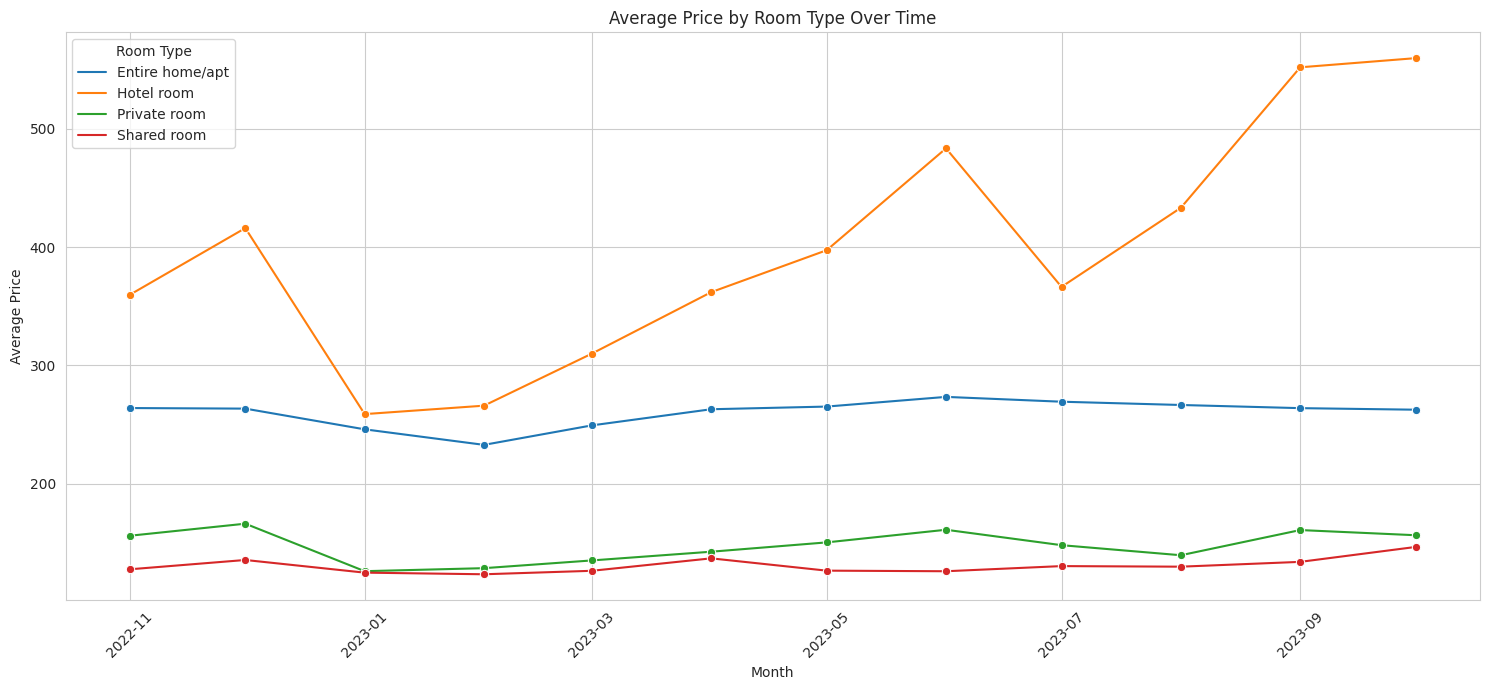

In [ ]:
# Visualize the average price by room type over time

price_by_room_type = pd.concat([pre_law_price_by_room_type, post_law_price_by_room_type]).reset_index()

# Now let's melt the dataframe so that it's in long-form for plotting with seaborn
price_by_room_type_melted = price_by_room_type.melt(id_vars=['month'], var_name='Room Type', value_name='Average Price')

# Plot
plt.figure(figsize=(15, 7))
sns.lineplot(data=price_by_room_type_melted, x='month', y='Average Price', hue='Room Type', marker='o')
plt.title('Average Price by Room Type Over Time')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend(title='Room Type')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


## change in the number of Airbnb listings in the top N neighbourhoods

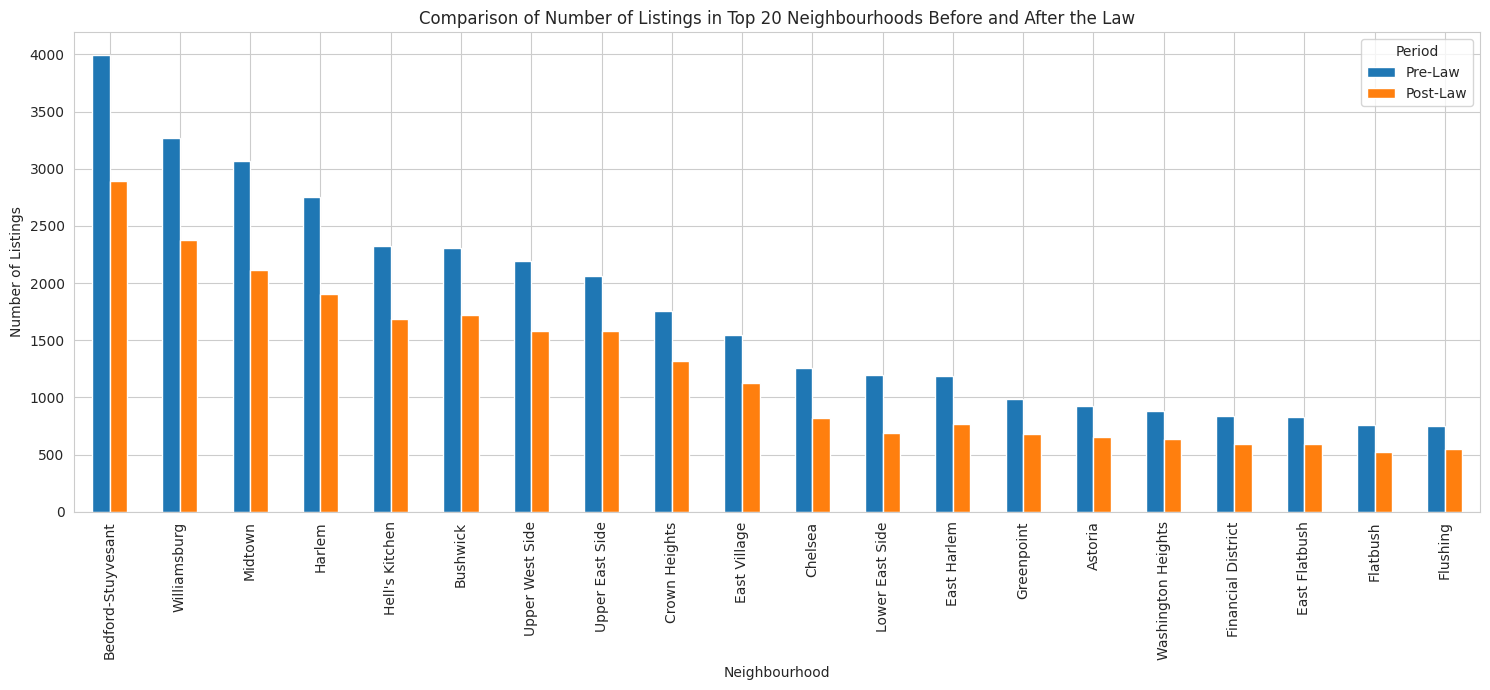

6.903538878269135e-08

In [ ]:
def visualize_and_test_neighbourhood_changes(file_paths, top_n_neighbourhoods):
    """
    Visualize and perform a statistical test on the change in the number of Airbnb listings in the top N neighbourhoods
    before and after the implementation of a new law.

    Parameters:
    - file_paths: List of file paths to the monthly Airbnb summary listings data.
    - top_n_neighbourhoods: The number of top neighbourhoods to consider for the analysis.

    Returns:
    - p_value from the statistical test.
    """
    # Combine all datasets into one DataFrame
    combined_data = pd.DataFrame()
    for file_path in file_paths:
        # Load the current month's data
        current_month_data = pd.read_csv(file_path)
        # Extract the month from the file name
        month = pd.to_datetime(file_path.split('_')[-1].split('.')[0], format='%Y%m')
        # Add the month as a column in the DataFrame
        current_month_data['month'] = month
        # Append to the combined DataFrame
        combined_data = pd.concat([combined_data, current_month_data], ignore_index=True)


    # Calculate the number of listings by neighbourhood before and after the law took effect
    pre_law_data = combined_data[combined_data['month'] < '2023-09']
    post_law_data = combined_data[combined_data['month'] >= '2023-09']
    pre_law_neighbourhood_listings = pre_law_data.groupby('neighbourhood')['id'].nunique()
    post_law_neighbourhood_listings = post_law_data.groupby('neighbourhood')['id'].nunique()

    # Determine the top N neighbourhoods based on the number of listings before the law
    top_neighbourhoods = pre_law_neighbourhood_listings.sort_values(ascending=False).head(top_n_neighbourhoods).index

    # Filter the data to only include these top neighbourhoods
    neighbourhood_listings_comparison = pd.DataFrame({
        'Pre-Law': pre_law_neighbourhood_listings,
        'Post-Law': post_law_neighbourhood_listings
    }).loc[top_neighbourhoods].fillna(0)

    # Visualize the comparison for the top N neighbourhoods
    neighbourhood_listings_comparison.plot(kind='bar', figsize=(15, 7))
    plt.title(f'Comparison of Number of Listings in Top {top_n_neighbourhoods} Neighbourhoods Before and After the Law')
    plt.xlabel('Neighbourhood')
    plt.ylabel('Number of Listings')
    plt.xticks(rotation=90)
    plt.legend(title='Period')
    plt.tight_layout()
    plt.show()

    # Perform a paired t-test on the top N neighbourhoods
    t_stat, p_value = stats.ttest_rel(
        neighbourhood_listings_comparison['Pre-Law'],
        neighbourhood_listings_comparison['Post-Law']
    )

    return p_value

# usage:

# Visualize and test the top 20 neighbourhoods
visualize_and_test_neighbourhood_changes(file_paths, 20)
